# Data Analysis of Aspire's customers

From 08/21 - 12/21 I worked at [Aspire](https://aspireapp.com/), a FinTech startup based in the SEA region, as an Business Intelligence Intern. During my internship, I had the opportunity to gather insights from data the company had via an exploratory data analysis (EDA). In this file, using synthetic data I generated based on the data I have worked with, I attempt to showcase the skills and techniques I used to gerenate insights.  

## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from operator import attrgetter 

# general purpose data manipluation libraries/packages
import pandas as pd
import numpy as np

# data visualisation libraries/packages
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# statistical modelling & tests libraries/packages
import statsmodels.stats.multicomp as multi
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# machine learning modelling libraries/packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# aesthetics 
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
%matplotlib inline

## [Cohort Analysis](https://clevertap.com/blog/cohort-analysis/)

I start off the EDA with a bird's eye view on the retention rates of customers grouped by the first month they interacted with Aspire as cohorts.

In this analysis, accounts are usually grouped by the first year-month they take their first action (determined by the company). 

This aggregation is does not take into account that accounts onboarded within the same month can exhibit wildly different behaviour, but it is okay in this scenario since it allows us to better track the effectiveness of marketing campaigns or external events that may affect retention or onboarding efforts.

### Reading in event log

In [2]:
df = pd.read_csv('df_git.csv', parse_dates=['event_date']).drop(columns=['Unnamed: 0'])

In [3]:
# Processing the event log for cohort analysis

cohort_train = df[['id','event_id','event_date']]
cohort_train['year_month'] = cohort_train['event_date'].dt.to_period('M')
cohort_train['cohort'] = cohort_train.groupby('id')['event_date'].transform('min').dt.to_period('M')

df_cohort = cohort_train.groupby(['cohort', 'year_month']).agg(n_customers=('id', 'nunique')).reset_index(drop=False)
df_cohort['M'] = (df_cohort.year_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort = df_cohort[df_cohort['cohort'] != '2020-05']

cohort_pivot = df_cohort.pivot_table(index = 'cohort', columns = 'M', values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

# Reusing the cohort analysis data to draw Retention Curve
df_cohort_curve = df_cohort.merge(df_cohort[df_cohort['cohort'] == df_cohort['year_month']][['cohort','n_customers']], how='left', on='cohort')
df_cohort_curve['percent'] = df_cohort_curve['n_customers_x'] / df_cohort_curve['n_customers_y']

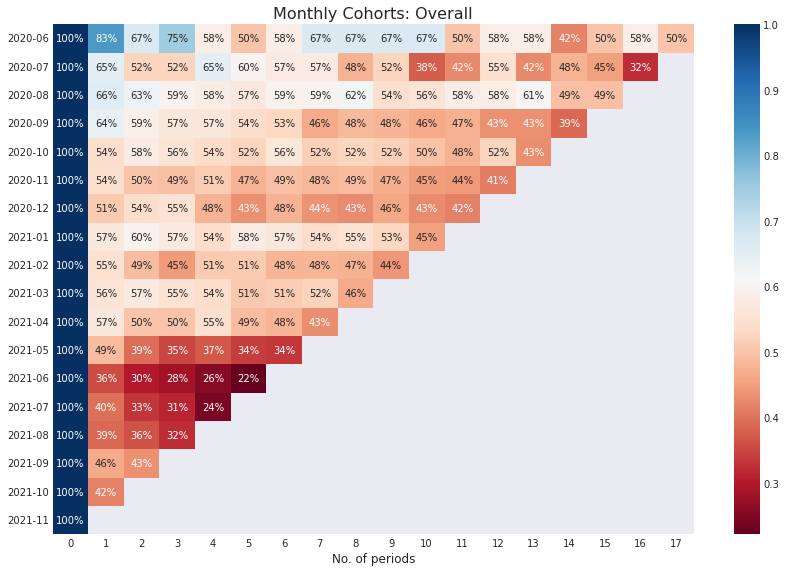

In [4]:
# Cohort Analysis Plot
with sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, fmt='.0%', cmap='RdBu')
    ax.set_title('Monthly Cohorts: Overall', fontsize=16)
    ax.set(xlabel='No. of periods', ylabel='')
    fig.tight_layout()

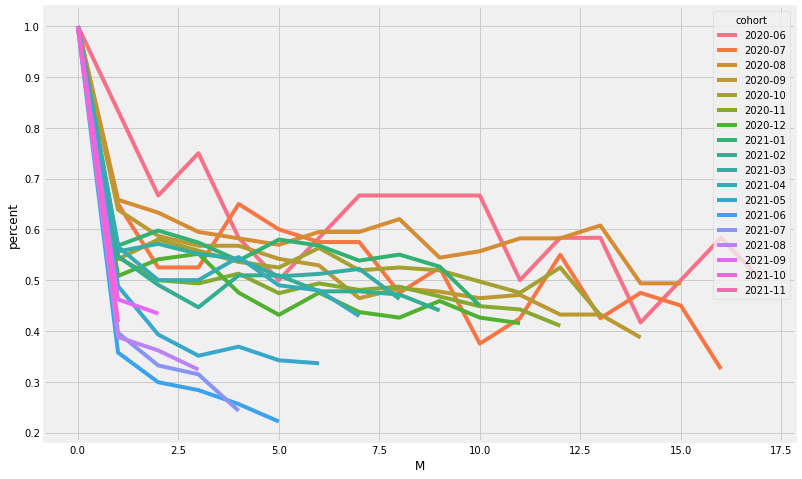

In [5]:
# Retention Curve Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
g = sns.lineplot('M','percent',hue='cohort',data=df_cohort_curve)

### Quick Insights

* Cohort Analysis:
    * There is a dark spot for cohorts between 05/21 to 08/21.
* Retention Curve:   
    * There is a clear separation in terms of retention rates for cohorts between 05/21 to 08/21 relative to other cohorts.
* Overall Insights:
    * Typical retention hovers between 40% ~ 50% which is good.
    * However, cohorts between 05/21 to 08/21 have churned faster than expected.


# Gist of the further data analysis process

The goal is to use K-means clustering as well RFM analysis to segment these customers based on their usage of Aspire's porducts. We can indentify valuable customers have/are about to churn to proactively, retain them. We can indentify promising customers to make them power users. 

After much reiteration, I initally decided that 3 clusters would be the ideal clustering solution (e.g, Chruned User, Adjacent User, Power User).

Looking through the distribution of the `recency`, `frequency` as well as `monetary` value of their spending, the distributions were heavily skewed to the left (Positive Skew). .

Therefore I did an intial logarithmic transformation to these attributes to make them follow a more gaussian distribution. I also needed to transform the `recency` values as currently larger values might be interpreted as being more desirable, thus I just multiplied the values by -1 to flip the scale such as the least negative log'd recency values (closer to 0 in original scale) would be interpreted as being more desirable.

[This article explains more about logarithmic scales.](https://towardsdatascience.com/logarithms-what-why-and-how-ff9d050d3fd7) The quick answer is that I want to place on emphasis on increaases in the smaller side of the range for a given attribute (an increase from 10 --> 100 is more important than from 200 --> 290 since the latter is probably already an avid user while the former has great potential to become an avid user, there might be a diminishing to focus Customer Relationship Management (CRM) efforts on the latter groups.

In [6]:
# Reading more account information data on accounts from the 05/21 to 08/21 cohorts (about 3,200 accounts).
df2 = pd.read_csv('05210821_2021-12-14_1111.csv')

In [7]:
df2['avg_txn'] = df2['monetary'] / df2['frequency']

In [9]:
# Logarihtmic transformation
df2['frequency_log'] = np.log10(df2['frequency']) 
df2['monetary_log'] = np.log10(df2['monetary']) 
df2['recency_log'] = np.log1p(df2['recency']) * -1
df2['avg_txn_log'] = np.log10(df2['avg_txn'])

In [11]:
# Creating separate dataset with only numerical attributes for subsequent data transformation and modelling
df_clust_1 = df2.select_dtypes(include=np.number)

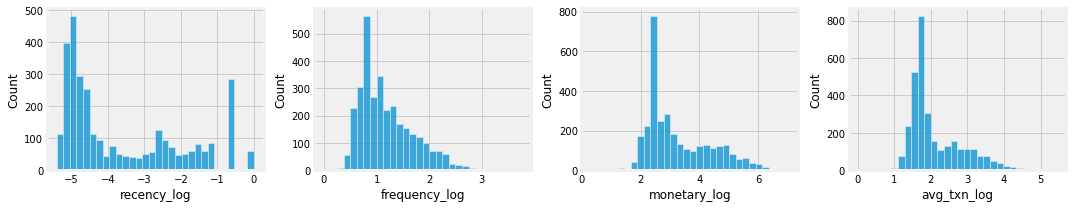

In [12]:
# Visualing distribution of numerical attributes 
fig, ax = plt.subplots(1, 4, figsize=(15,3))
g = sns.histplot(data=df_clust_1, x="recency_log", bins=30, ax=ax[0])
g = sns.histplot(data=df_clust_1, x="frequency_log", bins=30, ax=ax[1])
g = sns.histplot(data=df_clust_1, x="monetary_log", bins=30, ax=ax[2])
g = sns.histplot(data=df_clust_1, x="avg_txn_log", bins=30, ax=ax[3])
plt.tight_layout()

## K-Means Clsutering Modeling

The silhouette score can be interpreted as the "ease" of the clustering algorithm in segementing the data into unique groups, the higher the score the easier it is to find the specified number of unique groupings.

SSE (Sum of Squared Errors) measures the how similar data point are within their cluster, the lower the number the more homogenous the cluster is.

In [13]:
for n in range (2, 11):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init = 30)
    kmeans.fit(df_clust_1[['recency_log','frequency_log','avg_txn_log']])
    clusters = kmeans.predict(df_clust_1[['recency_log','frequency_log','avg_txn_log']])
    sil_avg = silhouette_score(df_clust_1[['recency_log','frequency_log','avg_txn_log']], clusters)
    print("For n_clusters : ", n, "The average silhouette_score is : ", sil_avg)

For n_clusters :  2 The average silhouette_score is :  0.6448350930830239
For n_clusters :  3 The average silhouette_score is :  0.5578283894220561
For n_clusters :  4 The average silhouette_score is :  0.5566682924144114
For n_clusters :  5 The average silhouette_score is :  0.515704295722418
For n_clusters :  6 The average silhouette_score is :  0.4608026885660993
For n_clusters :  7 The average silhouette_score is :  0.42671816765417003
For n_clusters :  8 The average silhouette_score is :  0.4193578222770105
For n_clusters :  9 The average silhouette_score is :  0.312651328720665
For n_clusters :  10 The average silhouette_score is :  0.30285362391120624


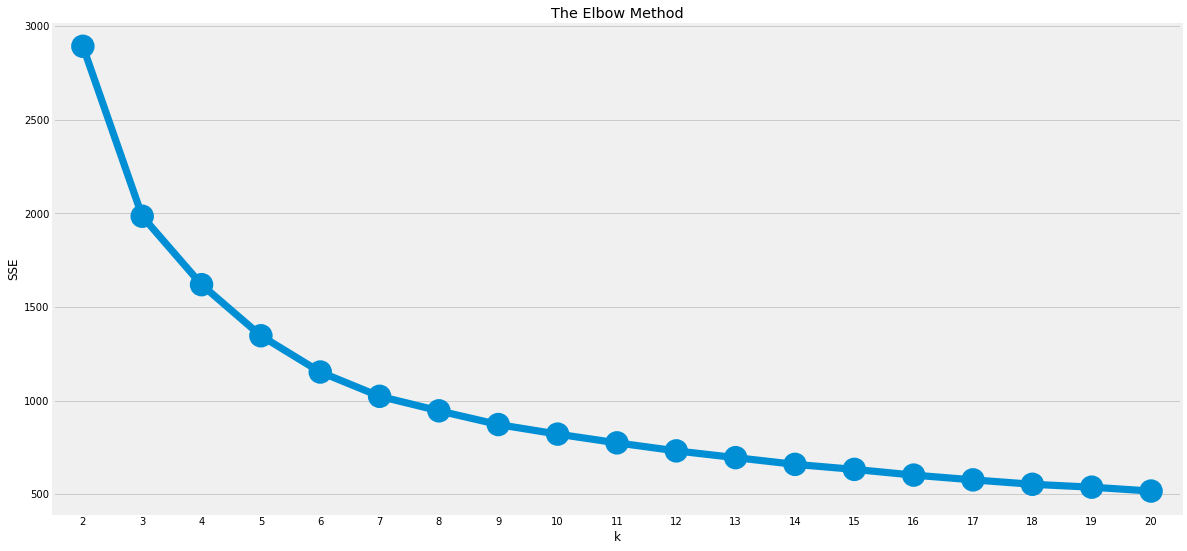

In [14]:
sse = {}

for k in range(2, 21):  
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=1)
    kmeans.fit(df_clust_1[['recency_log','frequency_log','avg_txn_log']])
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(18,9))
plt.ticklabel_format(style='plain', axis='y')

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### A 4 cluster model is the most optimal solution as it balances both the interpretability and uniqueness of each cluster. 

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42) 
kmeans.fit(df_clust_1[['recency_log','frequency_log','avg_txn_log']])
cluster_labels = kmeans.labels_
df2 = df2.assign(cluster=cluster_labels)
grouped = df2.groupby(['cluster'])
grouped_ = grouped.agg({
    'frequency_log': ['count','mean'],
    'monetary_log': ['mean'],
    'recency_log': ['mean'],
    'avg_txn_log': ['mean'],
  }).round(2)

grouped_.columns = grouped_.columns.droplevel(1)#.reset_index()
grouped_.reset_index()

,cluster,frequency_log,frequency_log,monetary_log,recency_log,avg_txn_log
0,0,304,1.44,4.81,-2.90,3.37
1,1,1837,0.88,2.60,-4.80,1.73
2,2,580,1.92,4.72,-0.92,2.81
3,3,464,1.31,3.21,-2.60,1.90


In [16]:
grouped_ = grouped.agg({
    'frequency_log': ['count','mean'],
    'monetary_log': ['mean'],
    'recency_log': ['mean'],
    'avg_txn_log': ['mean'],
  }).round(2)

grouped_.columns = grouped_.columns.droplevel(1)#.reset_index()
grouped_.reset_index()

,cluster,frequency_log,frequency_log,monetary_log,recency_log,avg_txn_log
0,0,304,1.44,4.81,-2.90,3.37
1,1,1837,0.88,2.60,-4.80,1.73
2,2,580,1.92,4.72,-0.92,2.81
3,3,464,1.31,3.21,-2.60,1.90


<AxesSubplot:xlabel='count', ylabel='cluster'>

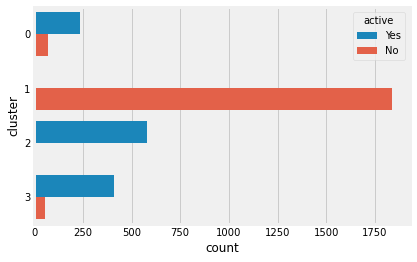

In [17]:
sns.countplot(
    y="cluster", 
    hue='active', 
    data=df2, 
    order=np.sort(df2.cluster.unique())
)

## Statistical Analysis using 1-way ANOVA

In [18]:
clust_anova = multi.MultiComparison(df2['monetary_log'], df2['cluster'])
results = clust_anova.tukeyhsd()
print(results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -2.2103  0.001 -2.3017  -2.119   True
     0      2  -0.0897 0.1217 -0.1942  0.0148  False
     0      3  -1.6084  0.001 -1.7173 -1.4995   True
     1      2   2.1206  0.001  2.0504  2.1909   True
     1      3   0.6019  0.001  0.5253  0.6786   True
     2      3  -1.5187  0.001 -1.6106 -1.4268   True
----------------------------------------------------


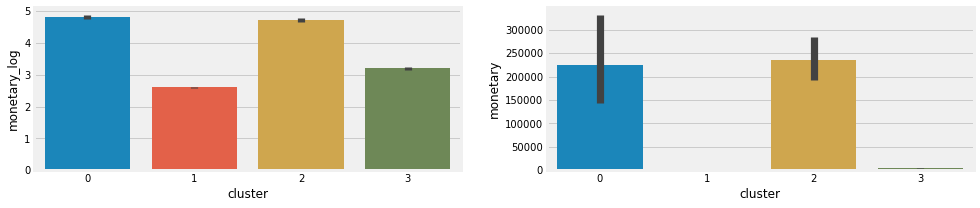

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))
g = sns.barplot(x="cluster", y="monetary_log", data=df2, alpha=1, estimator=np.mean, ci=95, ax=ax[0])
g = sns.barplot(x="cluster", y="monetary", data=df2, alpha=1, estimator=np.mean, ci=95, ax=ax[1])

In [20]:
clust_anova = multi.MultiComparison(df2['frequency_log'], df2['cluster'])
results = clust_anova.tukeyhsd()
print(results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   -0.563 0.001 -0.6136 -0.5125   True
     0      2   0.4765 0.001  0.4187  0.5343   True
     0      3  -0.1313 0.001 -0.1916  -0.071   True
     1      2   1.0395 0.001  1.0006  1.0784   True
     1      3   0.4317 0.001  0.3893  0.4742   True
     2      3  -0.6078 0.001 -0.6587 -0.5569   True
---------------------------------------------------


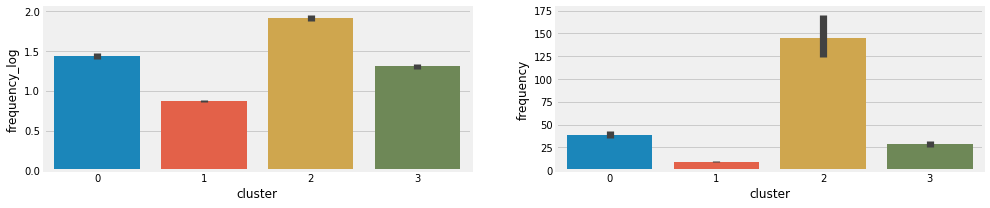

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))
g = sns.barplot(x="cluster", y="frequency_log", data=df2, alpha=1, estimator=np.mean, ci=95, ax=ax[0])
g = sns.barplot(x="cluster", y="frequency", data=df2, alpha=1, estimator=np.mean, ci=95, ax=ax[1])

In [22]:
clust_anova = multi.MultiComparison(df2['avg_txn_log'], df2['cluster'])
results = clust_anova.tukeyhsd()
print(results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -1.6473 0.001 -1.7164 -1.5782   True
     0      2  -0.5662 0.001 -0.6452 -0.4872   True
     0      3  -1.4771 0.001 -1.5595 -1.3948   True
     1      2   1.0811 0.001  1.0279  1.1343   True
     1      3   0.1702 0.001  0.1122  0.2282   True
     2      3  -0.9109 0.001 -0.9804 -0.8414   True
---------------------------------------------------


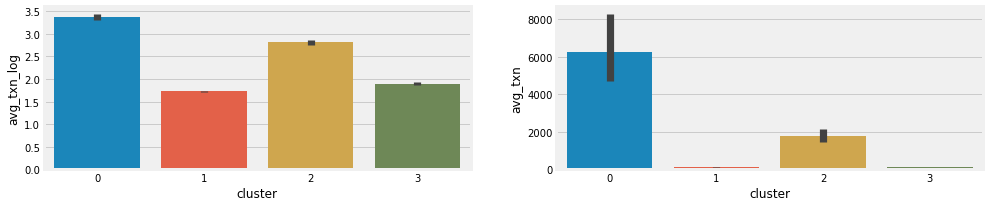

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))
g = sns.barplot(x="cluster", y="avg_txn_log", data=df2, alpha=1, estimator=np.mean, ci=95, ax=ax[0])
g = sns.barplot(x="cluster", y="avg_txn", data=df2, alpha=1, estimator=np.mean, ci=95, ax=ax[1])

## Renaming clusters
                           
Cluster `0` has the monetary characteristics of Cluster 1 while also having the frequency characteristics, I will name them `Whales` since when they spend they spend really big.
 * Has average freqency value of about `40`. (More similar to `Normal` cluster)
 * Has average total spending of about `$225,000`. (More similar to `Power` cluster)
 * Has defining feature with average transaction value of about `$6,000`. 

Cluster `3` has no active users, they will be named `Churned`
 * Has average freqency value of about `10`.
 * Has average total spending of about `$500`.  (After "anti-logging" the logarithmic value of about 2.7 log 10)
 * Has average transaction value of about `$50`. (After "anti-logging" the logarithmic value of about 1.7 log 10)

Cluster `1` has both high frequency and monetary, they will be named `Power`
 * Has defining feature with an average freqency value of about `150`. 
 * Has average total spending of about `$225,000`. 
 * Has average transaction value of about `$2,000`. 

Cluster `2` will be named `Normal`
 * Has average freqency value of about `25`.
 * Has average total spending of about `$1,600`.  (After "anti-logging" the logarithmic value of about 3.1 log 10)
 * Has average transaction value of about `$80`. (After "anti-logging" the logarithmic value of about 1.9 log 10)

In [24]:
conditions = [
    df2['cluster'].isin([0]),   
    df2['cluster'].isin([1]),
    df2['cluster'].isin([2]), 
    df2['cluster'].isin([3])
]
choices = [
    'Whale',
    'Power',
    'Normal',
    'Churned'
]
df2['new_cluster'] = np.select(conditions, choices, default = '1.churned')

## Data visualisations

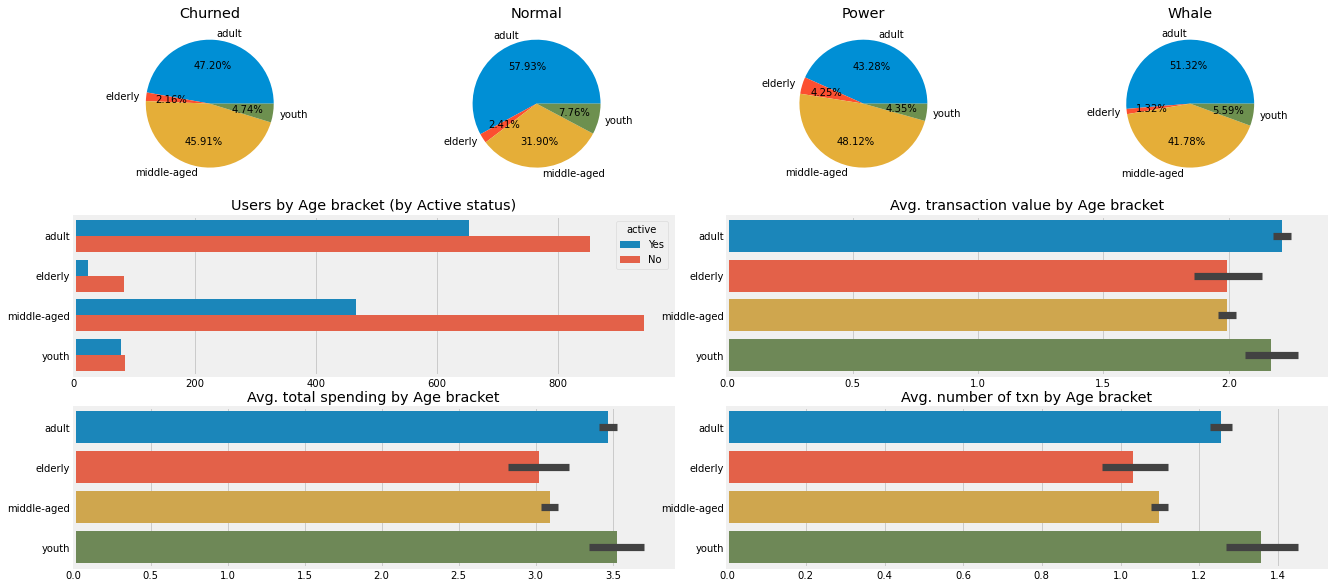

In [25]:
fig = plt.figure(figsize=(20,10))
# subplots for pie charts
ax1 = plt.subplot2grid((3,4), (0,0))
ax2 = plt.subplot2grid((3,4), (0,1))
ax3 = plt.subplot2grid((3,4), (0,2))
ax4 = plt.subplot2grid((3,4), (0,3))
# subplots for barplot, barcharts
ax5 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax6 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax7 = plt.subplot2grid((3,4), (2,0), colspan=2)
ax8 = plt.subplot2grid((3,4), (2,2), colspan=2)

sns.countplot(y="age_bracket", hue="active", data=df2, order=np.sort(df2.age_bracket.unique()), ax=ax5)
ax5.set(xlabel='', ylabel='')
ax5.set_title('Users by Age bracket (by Active status)')

sns.barplot(x="avg_txn_log", y="age_bracket",data=df2, alpha=1, order=np.sort(df2.age_bracket.unique()), estimator=np.mean, ci=95, ax=ax6)
ax6.set(xlabel='', ylabel='')
ax6.set_title('Avg. transaction value by Age bracket')

sns.barplot(x="monetary_log", y="age_bracket",data=df2, alpha=1, order=np.sort(df2.age_bracket.unique()), estimator=np.mean, ci=95, ax=ax7)
ax7.set(xlabel='', ylabel='')
ax7.set_title('Avg. total spending by Age bracket')

sns.barplot(x="frequency_log", y="age_bracket",data=df2, alpha=1, order=np.sort(df2.age_bracket.unique()), estimator=np.mean, ci=95, ax=ax8)
ax8.set(xlabel='', ylabel='')
ax8.set_title('Avg. number of txn by Age bracket')

grpby_clust_age = df2.groupby(['new_cluster','age_bracket'])['debit_account_id'].count().reset_index().rename({'debit_account_id': 'count'}, axis=1)
ax = [ax1,ax2,ax3,ax4]

for ax, cluster in zip( ax, np.sort(df2.new_cluster.unique()) ):
    values = grpby_clust_age[grpby_clust_age['new_cluster']==cluster]['count'].values
    labels = grpby_clust_age[grpby_clust_age['new_cluster']==cluster]['age_bracket'].values
    
    ax.pie(values, labels=labels, autopct='%.2f%%')
    ax.set_title(cluster)

## Insights
 * The more valuable the customer (Churned users -> Normal -> Power / Whale), the more likely they are to be from the `youth` or `adult` age bracket.
 * As can be seen that `youth` or `adult` age bracket spend more, more frequently and have greater average transaction values than the `middle-age` or `elderly` age bracket.

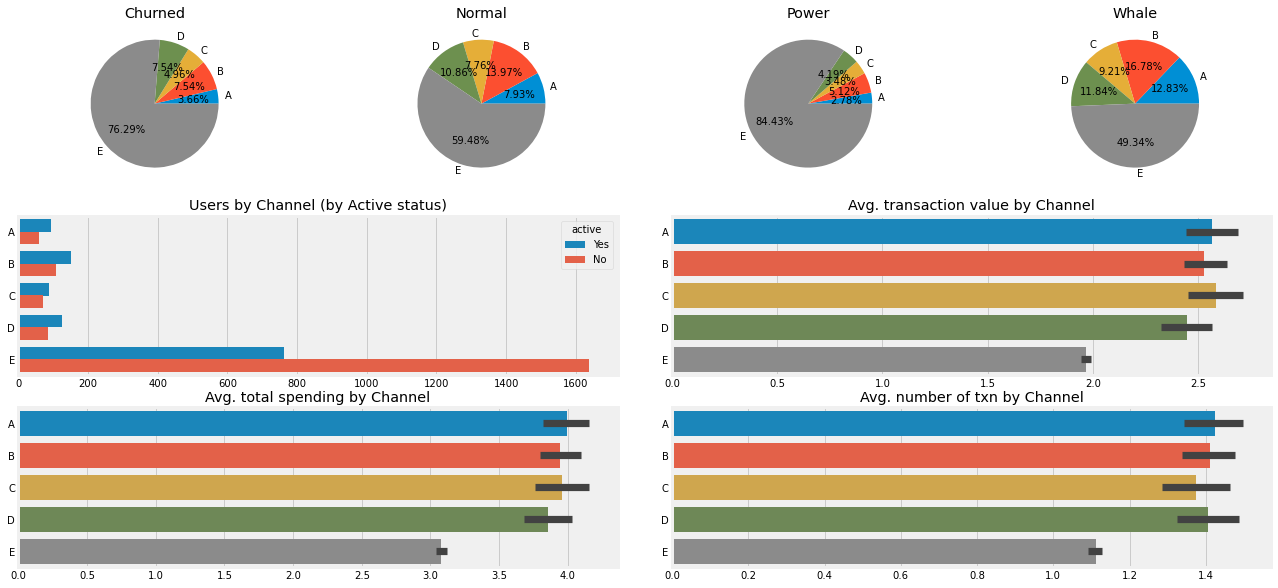

In [26]:
fig = plt.figure(figsize=(20,10))
# subplots for pie charts
ax1 = plt.subplot2grid((3,4), (0,0))
ax2 = plt.subplot2grid((3,4), (0,1))
ax3 = plt.subplot2grid((3,4), (0,2))
ax4 = plt.subplot2grid((3,4), (0,3))
# subplots for barplot, barcharts
ax5 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax6 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax7 = plt.subplot2grid((3,4), (2,0), colspan=2)
ax8 = plt.subplot2grid((3,4), (2,2), colspan=2)

sns.countplot(y="macro_acquisition_channel", hue="active", data=df2, order=np.sort(df2.macro_acquisition_channel.unique()), ax=ax5)
ax5.set(xlabel='', ylabel='')
ax5.set_title('Users by Channel (by Active status)')

sns.barplot(x="avg_txn_log", y="macro_acquisition_channel",data=df2, alpha=1, order=np.sort(df2.macro_acquisition_channel.unique()), estimator=np.mean, ci=95, ax=ax6)
ax6.set(xlabel='', ylabel='')
ax6.set_title('Avg. transaction value by Channel')

sns.barplot(x="monetary_log", y="macro_acquisition_channel",data=df2, alpha=1, order=np.sort(df2.macro_acquisition_channel.unique()), estimator=np.mean,ci=95, ax=ax7)
ax7.set(xlabel='', ylabel='')
ax7.set_title('Avg. total spending by Channel')

sns.barplot(x="frequency_log", y="macro_acquisition_channel",data=df2, alpha=1, order=np.sort(df2.macro_acquisition_channel.unique()),estimator=np.mean, ci=95, ax=ax8)
ax8.set(xlabel='', ylabel='')
ax8.set_title('Avg. number of txn by Channel')

grpby_clust_age = df2.groupby(['new_cluster','macro_acquisition_channel'])['debit_account_id'].count().reset_index().rename({'debit_account_id': 'count'}, axis=1)
ax = [ax1,ax2,ax3,ax4]

for ax, cluster in zip( ax, np.sort(df2.new_cluster.unique()) ):
    values = grpby_clust_age[grpby_clust_age['new_cluster']==cluster]['count'].values
    labels = grpby_clust_age[grpby_clust_age['new_cluster']==cluster]['macro_acquisition_channel'].values
    
    ax.pie(values, labels=labels, autopct='%.2f%%')
    ax.set_title(cluster)

## Insights
 * The more valuable the customer (Churned users -> Normal -> Power / Whale), the less likely they are to be from macro acquisition channel `E`.
 * As can be seen that channels `A`, `B`, `C` & `D` spend more, more frequently and have greater average transaction values than channel `E` .

## [RFM Analysis](https://akcakayaonur.medium.com/rfm-model-and-customer-segmentation-8939c41efc0d)
 * [Additional resource](https://stacktome.com/blog/rfm-customer-segmentation)
 * K-Means clustering is not a fool-proof way to analyse the data, there could be outliers within the clusters (a user within the `power` users segment that behaves more like a user from the `normal` user segment).
 * Therefore, I will cross-tabulate the results from both K-Means clustering & RFM segmentation to identify outliers/anomalies worth prioritising for CRM.

In [27]:
df2['recency_score'] = pd.qcut(df2['recency'], 5, labels = [5,4,3,2,1]).astype(int)
df2['frequency_score'] = pd.qcut(df2['frequency'], 5, labels = [1,2,3,4,5]).astype(int)
df2['monetary_score'] = pd.qcut(df2['monetary'], 5, labels = [1,2,3,4,5]).astype(int)
df2['RFMScore'] = df2['recency_score'].astype(str) + df2['frequency_score'].astype(str) + df2['monetary_score'].astype(str)

cust_segment_map = {
    r'[1-2][1-2]': "Hibernating",
    r'[1-2][3-4]': "At risk",
    r'[1-2]5': "Cant Lose",
    r'3[1-2]': "About to sleep",
    r'33': "Needs attention",
    r'[3-4][4-5]': "Loyal customers",
    r'41': "Promsing",
    r'51': "New customers",
    r'[4-5][2-3]': "Potential loyal customers",
    r'5[4-5]': "Champions",
}
df2['Segment'] = df2['recency_score'].astype(str) + df2['frequency_score'].astype(str)
df2['Segment'] = df2['Segment'].replace(cust_segment_map, regex = True)

<AxesSubplot:xlabel='count', ylabel='Segment'>

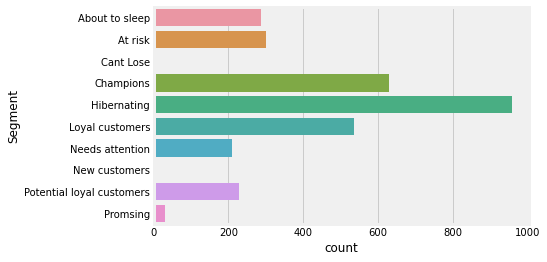

In [28]:
sns.countplot(y="Segment", data=df2, alpha=1, order=np.sort(df2.Segment.unique()))

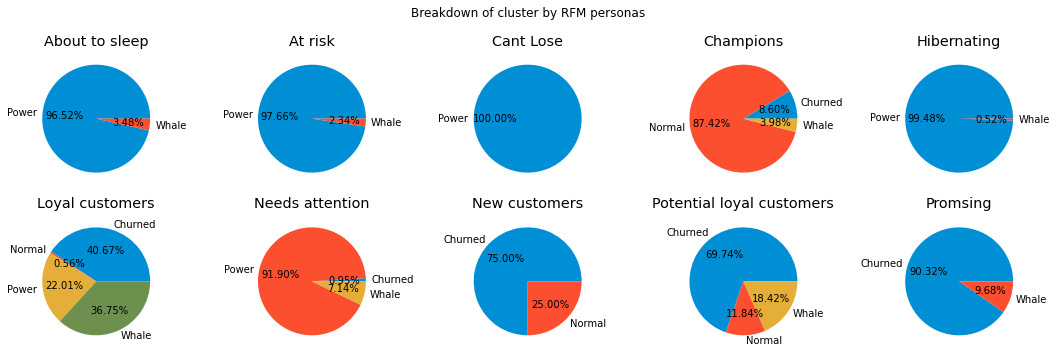

In [29]:
fig, ax = plt.subplots(2, 5, figsize=(15,5))
grpby_clust_macro = df2.groupby(['Segment','new_cluster'])['debit_account_id'].count().reset_index().rename({'debit_account_id': 'count'}, axis=1)
ax = np.ravel(ax)
for i, cluster in enumerate(np.sort(df2.Segment.unique())):
    values = grpby_clust_macro[grpby_clust_macro['Segment'] == cluster]['count'].values
    labels = grpby_clust_macro[grpby_clust_macro['Segment'] == cluster]['new_cluster'].values
    ax[i].pie(values, labels = labels, autopct='%.2f%%');
    ax[i].set_title(cluster)
    
ax = np.reshape(ax, (2, 5))
fig.patch.set_facecolor('white')
fig.suptitle('Breakdown of cluster by RFM personas')
plt.tight_layout()

#  Concluding Insights

* Marketing Channel:
    * There seems to be a trend where if a user came from channel `E`, the more likely they will to churn.
    * Maybe Aspire should revisit this marketing channel to see why users dont stick.
    
* Cluster & RFM segmentation Cross-Tabulation:   
    * Identified outliers within the natural groupings (e.g Normal users in the Champions RFM persona) with great potential.
    * Identified such users to coduct proactive CRM to retain them.
    
* Simplicity:
    * Referring to the 95% CI bands, we could create a simpler way to segement our users in systems such as databases and BI tools without the need to use an unsupervised machine learning model. 